# Test U-Net++ on validation & test sets

In [4]:
!wget https://raw.githubusercontent.com/wanghao14/Stain_Normalization/master/stain_utils.py
!wget https://raw.githubusercontent.com/wanghao14/Stain_Normalization/master/stainNorm_Macenko.py
!pip install spams

--2023-02-04 08:25:23--  https://raw.githubusercontent.com/wanghao14/Stain_Normalization/master/stain_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4255 (4.2K) [text/plain]
Saving to: ‘stain_utils.py.1’

stain_utils.py.1    100%[===================>]   4.16K  --.-KB/s    in 0s      

2023-02-04 08:25:23 (51.4 MB/s) - ‘stain_utils.py.1’ saved [4255/4255]

--2023-02-04 08:25:23--  https://raw.githubusercontent.com/wanghao14/Stain_Normalization/master/stainNorm_Macenko.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 266

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import time
import os
import cv2
import numpy as np
import pandas as pd
import glob
import random
import shutil
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import stain_utils as utils
import stainNorm_Macenko

from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score

from skimage import filters
from skimage.color import label2rgb
from skimage import morphology
from scipy.ndimage import measurements
from skimage.segmentation import watershed, mark_boundaries

from scipy.optimize import linear_sum_assignment

## Defining the model

In [7]:
# https://github.com/yingkaisha/keras-unet-collection
!pip install keras_unet_collection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 KB 7.6 MB/s eta 0:00:00


In [8]:
# -*- coding: utf-8 -*-
"""unet_plusplus_2d.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1khOW6qBIJD-HY7LDQxJScICMMDzFbCGG
"""

from keras_unet_collection.layer_utils import *
from keras_unet_collection.activations import GELU, Snake
from keras_unet_collection._backbone_zoo import backbone_zoo, bach_norm_checker
from keras_unet_collection._model_unet_2d import UNET_left, UNET_right

from keras.layers import Input
from keras.models import Model

import warnings

def unet_plus_2d_base(input_tensor, filter_num, stack_num_down=2, stack_num_up=2,
                      activation='ReLU', batch_norm=False, pool=True, unpool=True, deep_supervision=False, 
                      backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='xnet'):
    '''
    The base of U-net++ with an optional ImageNet-trained backbone
    
    unet_plus_2d_base(input_tensor, filter_num, stack_num_down=2, stack_num_up=2,
                      activation='ReLU', batch_norm=False, pool=True, unpool=True, deep_supervision=False, 
                      backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='xnet')
    
    ----------
    Zhou, Z., Siddiquee, M.M.R., Tajbakhsh, N. and Liang, J., 2018. Unet++: A nested u-net architecture 
    for medical image segmentation. In Deep Learning in Medical Image Analysis and Multimodal Learning 
    for Clinical Decision Support (pp. 3-11). Springer, Cham.
    
    Input
    ----------
        input_tensor: the input tensor of the base, e.g., `keras.layers.Inpyt((None, None, 3))`.
        filter_num: a list that defines the number of filters for each \
                    down- and upsampling levels. e.g., `[64, 128, 256, 512]`.
                    The depth is expected as `len(filter_num)`.
        stack_num_down: number of convolutional layers per downsampling level/block. 
        stack_num_up: number of convolutional layers (after concatenation) per upsampling level/block.
        activation: one of the `tensorflow.keras.layers` or `keras_unet_collection.activations` interfaces, e.g., 'ReLU'.
        batch_norm: True for batch normalization.
        pool: True or 'max' for MaxPooling2D.
              'ave' for AveragePooling2D.
              False for strided conv + batch norm + activation.
        unpool: True or 'bilinear' for Upsampling2D with bilinear interpolation.
                'nearest' for Upsampling2D with nearest interpolation.
                False for Conv2DTranspose + batch norm + activation.   
        deep_supervision: True for a model that supports deep supervision. Details see Zhou et al. (2018).
        name: prefix of the created keras model and its layers.
        
        ---------- (keywords of backbone options) ----------
        backbone_name: the bakcbone model name. Should be one of the `tensorflow.keras.applications` class.
                       None (default) means no backbone. 
                       Currently supported backbones are:
                       (1) VGG16, VGG19
                       (2) ResNet50, ResNet101, ResNet152
                       (3) ResNet50V2, ResNet101V2, ResNet152V2
                       (4) DenseNet121, DenseNet169, DenseNet201
                       (5) EfficientNetB[0-7]
        weights: one of None (random initialization), 'imagenet' (pre-training on ImageNet), 
                 or the path to the weights file to be loaded.
        freeze_backbone: True for a frozen backbone.
        freeze_batch_norm: False for not freezing batch normalization layers.
        
    Output
    ----------
        If deep_supervision = False; Then the output is a tensor.
        If deep_supervision = True; Then the output is a list of tensors
            with the first tensor obtained from the first downsampling level (for checking the input/output shapes only),
            the second to the `depth-1`-th tensors obtained from each intermediate upsampling levels (deep supervision tensors),
            and the last tensor obtained from the end of the base.
    
    '''
    
    activation_func = eval(activation)

    depth_ = len(filter_num)
    # allocate nested lists for collecting output tensors 
    X_nest_skip_1 = [[] for _ in range(depth_)]
    X_nest_skip_2 = [[] for _ in range(depth_)]

    # no backbone cases
    if backbone is None:

        X = input_tensor

        # downsampling blocks (same as in 'unet_2d')
        X = CONV_stack(X, filter_num[0], stack_num=stack_num_down, activation=activation, 
                       batch_norm=batch_norm, name='{}_down0'.format(name))
        X_nest_skip_1[0].append(X)
        X_nest_skip_2[0].append(X)
        for i, f in enumerate(filter_num[1:]):
            X = UNET_left(X, f, stack_num=stack_num_down, activation=activation, 
                          pool=pool, batch_norm=batch_norm, name='{}_down{}'.format(name, i+1))        
            X_nest_skip_1[0].append(X)
            X_nest_skip_2[0].append(X)

    # backbone cases
    else:        
        # handling VGG16 and VGG19 separately
        if 'VGG' in backbone:
            backbone_ = backbone_zoo(backbone, weights, input_tensor, depth_, freeze_backbone, freeze_batch_norm)
            # collecting backbone feature maps
            X_nest_skip_1[0] += backbone_([input_tensor,])
            X_nest_skip_2[0] += backbone_([input_tensor,])
            depth_encode = len(X_nest_skip_1[0])
            depth_encode = len(X_nest_skip_2[0])

        # for other backbones
        else:
            backbone_ = backbone_zoo(backbone, weights, input_tensor, depth_-1, freeze_backbone, freeze_batch_norm)
            # collecting backbone feature maps
            X_nest_skip_1[0] += backbone_([input_tensor,])
            X_nest_skip_2[0] += backbone_([input_tensor,])
            depth_encode = len(X_nest_skip_1[0]) + 1
            depth_encode = len(X_nest_skip_2[0]) + 1

        # extra conv2d blocks are applied
        # if downsampling levels of a backbone < user-specified downsampling levels
        if depth_encode < depth_:

            # begins at the deepest available tensor  
            X = X_nest_skip_1[0][-1]
            X = X_nest_skip_2[0][-1]

            # extra downsamplings
            for i in range(depth_-depth_encode):
                i_real = i + depth_encode

                X = UNET_left(X, filter_num[i_real], stack_num=stack_num_down, activation=activation, pool=pool, 
                              batch_norm=batch_norm, name='{}_down{}'.format(name, i_real+1))
                X_nest_skip_1[0].append(X)
                X_nest_skip_2[0].append(X)

    for nest_lev in range(1, depth_):

        # depth difference between the deepest nest skip and the current upsampling  
        depth_lev = depth_-nest_lev

        # number of available encoded tensors
        depth_decode = len(X_nest_skip_1[nest_lev-1])

        # loop over individual upsamling levels
        for i in range(1, depth_decode):

            # collecting previous downsampling outputs
            previous_skip = []
            for previous_lev in range(nest_lev):
                previous_skip.append(X_nest_skip_1[previous_lev][i-1])

            # upsamping block that concatenates all available (same feature map size) down-/upsampling outputs
            X_nest_skip_1[nest_lev].append(
                UNET_right(X_nest_skip_1[nest_lev-1][i], previous_skip, filter_num[i-1], 
                           stack_num=stack_num_up, activation=activation, unpool=unpool, 
                           batch_norm=batch_norm, concat=True, name='{}_up{}_1_from{}'.format(name, nest_lev-1, i-1)))

        if depth_decode < depth_lev+1:

            X = X_nest_skip_1[nest_lev-1][-1]

            for j in range(depth_lev-depth_decode+1):
                j_real = j + depth_decode
                X = UNET_right(X, None, filter_num[j_real-1], 
                               stack_num=stack_num_up, activation=activation, unpool=unpool, 
                               batch_norm=batch_norm, concat=True, name='{}_up{}_from{}'.format(name, nest_lev-1, j_real-1))
                X_nest_skip_1[nest_lev].append(X)

    for nest_lev in range(1, depth_):

        # depth difference between the deepest nest skip and the current upsampling  
        depth_lev = depth_-nest_lev

        # number of available encoded tensors
        depth_decode = len(X_nest_skip_2[nest_lev-1])

        # loop over individual upsamling levels
        for i in range(1, depth_decode):

            # collecting previous downsampling outputs
            previous_skip = []
            for previous_lev in range(nest_lev):
                previous_skip.append(X_nest_skip_2[previous_lev][i-1])

            # upsamping block that concatenates all available (same feature map size) down-/upsampling outputs
            X_nest_skip_2[nest_lev].append(
                UNET_right(X_nest_skip_2[nest_lev-1][i], previous_skip, filter_num[i-1], 
                           stack_num=stack_num_up, activation=activation, unpool=unpool, 
                           batch_norm=batch_norm, concat=True, name='{}_up{}_2_from{}'.format(name, nest_lev-1, i-1)))

        if depth_decode < depth_lev+1:

            X = X_nest_skip_2[nest_lev-1][-1]

            for j in range(depth_lev-depth_decode+1):
                j_real = j + depth_decode
                X = UNET_right(X, None, filter_num[j_real-1], 
                               stack_num=stack_num_up, activation=activation, unpool=unpool, 
                               batch_norm=batch_norm, concat=True, name='{}_up{}_2_from{}'.format(name, nest_lev-1, j_real-1))
                X_nest_skip_2[nest_lev].append(X)
            
    # output
    if deep_supervision:
        
        X_list_1 = []
        X_list_2 = []
        
        for i in range(depth_):
            X_list_1.append(X_nest_skip_1[i][0])
            X_list_2.append(X_nest_skip_2[i][0])
        
        return X_list_1, X_list_2
        
    else:
        return X_nest_skip_1[-1][0], X_nest_skip_2[-1][0]

def unet_plus_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2,
                 activation='ReLU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, deep_supervision=False, 
                 backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='xnet'):
    '''
    U-net++ with an optional ImageNet-trained backbone.
    
    unet_plus_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2,
                 activation='ReLU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, deep_supervision=False, 
                 backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='xnet')
    
    ----------
    Zhou, Z., Siddiquee, M.M.R., Tajbakhsh, N. and Liang, J., 2018. Unet++: A nested u-net architecture 
    for medical image segmentation. In Deep Learning in Medical Image Analysis and Multimodal Learning 
    for Clinical Decision Support (pp. 3-11). Springer, Cham.
    
    Input
    ----------
        input_size: the size/shape of network input, e.g., `(128, 128, 3)`.
        filter_num: a list that defines the number of filters for each \
                    down- and upsampling levels. e.g., `[64, 128, 256, 512]`.
                    The depth is expected as `len(filter_num)`.
        n_labels: number of output labels.
        stack_num_down: number of convolutional layers per downsampling level/block. 
        stack_num_up: number of convolutional layers (after concatenation) per upsampling level/block.
        activation: one of the `tensorflow.keras.layers` or `keras_unet_collection.activations` interfaces, e.g., 'ReLU'.
        output_activation: one of the `tensorflow.keras.layers` or `keras_unet_collection.activations` interface or 'Sigmoid'.
                           Default option is 'Softmax'.
                           if None is received, then linear activation is applied.
        batch_norm: True for batch normalization.
        pool: True or 'max' for MaxPooling2D.
              'ave' for AveragePooling2D.
              False for strided conv + batch norm + activation.
        unpool: True or 'bilinear' for Upsampling2D with bilinear interpolation.
                'nearest' for Upsampling2D with nearest interpolation.
                False for Conv2DTranspose + batch norm + activation.   
        deep_supervision: True for a model that supports deep supervision. Details see Zhou et al. (2018).
        name: prefix of the created keras model and its layers.
        
        ---------- (keywords of backbone options) ----------
        backbone_name: the bakcbone model name. Should be one of the `tensorflow.keras.applications` class.
                       None (default) means no backbone. 
                       Currently supported backbones are:
                       (1) VGG16, VGG19
                       (2) ResNet50, ResNet101, ResNet152
                       (3) ResNet50V2, ResNet101V2, ResNet152V2
                       (4) DenseNet121, DenseNet169, DenseNet201
                       (5) EfficientNetB[0-7]
        weights: one of None (random initialization), 'imagenet' (pre-training on ImageNet), 
                 or the path to the weights file to be loaded.
        freeze_backbone: True for a frozen backbone.
        freeze_batch_norm: False for not freezing batch normalization layers.
        
    Output
    ----------
        model: a keras model.
    
    '''
    
    depth_ = len(filter_num)
    
    if backbone is not None:
        bach_norm_checker(backbone, batch_norm)
    
    IN = Input(input_size)
    # base
    X_1, X_2 = unet_plus_2d_base(IN, filter_num, stack_num_down=stack_num_down, stack_num_up=stack_num_up,
                          activation=activation, batch_norm=batch_norm, pool=pool, unpool=unpool, deep_supervision=deep_supervision, 
                          backbone=backbone, weights=weights, freeze_backbone=freeze_backbone, freeze_batch_norm=freeze_batch_norm, name=name)
    
    # output
    if deep_supervision:
        
        if (backbone is not None) and freeze_backbone:
            backbone_warn = '\n\nThe shallowest U-net++ deep supervision branch directly connects to a frozen backbone.\nTesting your configurations on `keras_unet_collection.base.unet_plus_2d_base` is recommended.'
            warnings.warn(backbone_warn);
            
        # model base returns a list of tensors
        X_list_1, X_list_2 = X_1, X_2
        OUT_list = []

        
        print('----------\ndeep_supervision = True\nnames of output tensors are listed as follows ("sup0" is the shallowest supervision layer;\n"final" is the final output layer):\n')
        
        # no backbone or VGG backbones
        # depth_ > 2 is expected (a least two downsampling blocks)
        if (backbone is None) or 'VGG' in backbone:
        
            for i in range(1, depth_-1):
                if output_activation is None:
                    print('\t{}_1_output_sup{}'.format(name, i))
                else:
                    print('\t{}_1_output_sup{}_activation'.format(name, i))
                    
                OUT_list.append(CONV_output(X_list_1[i], 1, kernel_size=1, activation="Sigmoid", 
                                            name='{}_1_output_sup{}'.format(name, i)))
        # other backbones        
        else:
            for i in range(1, depth_-1):
                if output_activation is None:
                    print('\t{}_output_sup{}'.format(name, i-1))
                else:
                    print('\t{}_output_sup{}_activation'.format(name, i-1))
                
                # an extra upsampling for creating full resolution feature maps
                X = decode_layer(X_list_1[i], filter_num[i], 2, unpool, activation=activation, 
                                 batch_norm=batch_norm, name='{}_sup{}_up'.format(name, i-1))
                
                X = CONV_output(X, n_labels, kernel_size=1, activation=output_activation, name='{}_output_sup{}'.format(name, i-1))
                OUT_list.append(X)
                
        if output_activation is None:
            print('\t{}_output_final'.format(name))
        else:
            print('\t{}_1_output_final_activation'.format(name))
            
        OUT_list.append(CONV_output(X_list_1[-1], 1, kernel_size=1, activation="Sigmoid", name='{}_1_output_final'.format(name)))

        # no backbone or VGG backbones
        # depth_ > 2 is expected (a least two downsampling blocks)
        if (backbone is None) or 'VGG' in backbone:
        
            for i in range(1, depth_-1):
                if output_activation is None:
                    print('\t{}_2_output_sup{}'.format(name, i))
                else:
                    print('\t{}_2_output_sup{}_activation'.format(name, i))
                    
                OUT_list.append(CONV_output(X_list_2[i], 3, kernel_size=1, activation="Softmax", 
                                            name='{}_2_output_sup{}'.format(name, i)))
        # other backbones        
        else:
            for i in range(1, depth_-1):
                if output_activation is None:
                    print('\t{}_output_sup{}'.format(name, i-1))
                else:
                    print('\t{}_output_sup{}_activation'.format(name, i-1))
                
                # an extra upsampling for creating full resolution feature maps
                X = decode_layer(X_list_2[i], filter_num[i], 2, unpool, activation=activation, 
                                 batch_norm=batch_norm, name='{}_sup{}_up'.format(name, i-1))
                
                X = CONV_output(X, n_labels, kernel_size=1, activation=output_activation, name='{}_output_sup{}'.format(name, i-1))
                OUT_list.append(X)
                
        if output_activation is None:
            print('\t{}_output_final'.format(name))
        else:
            print('\t{}_2_output_final_activation'.format(name))
            
        OUT_list.append(CONV_output(X_list_2[-1], 3, kernel_size=1, activation="Softmax", name='{}_2_output_final'.format(name)))
        
    else:
        OUT_1 = CONV_output(X_1, 1, kernel_size=1, activation='Sigmoid', name='Binary_segmentation')
        OUT_2 = CONV_output(X_2, 3, kernel_size=1, activation='Softmax', name='MultiClass_segmentation')
        OUT_list = [OUT_1, OUT_2]
        
    # model
    model = Model(inputs=[IN,], outputs=OUT_list, name='{}_model'.format(name))
    
    return model

In [9]:
model = unet_plus_2d(input_size=(1024, 1024, 3),
                     filter_num=[16, 32, 64, 128, 256],
                     n_labels=1,
                     batch_norm=True,
                     deep_supervision=True,
                     backbone="VGG19",
                     freeze_backbone=False,
                     freeze_batch_norm=False)

/usr/local/lib/python3.8/dist-packages/keras_unet_collection/_backbone_zoo.py:45: UserWarning: 

Backbone VGG19 does not use batch norm, but other layers received batch_norm=True
  warnings.warn(param_mismatch);


80134624/80134624 [==============================] - 4s 0us/step
----------
deep_supervision = True
names of output tensors are listed as follows ("sup0" is the shallowest supervision layer;
"final" is the final output layer):

	xnet_1_output_sup1_activation
	xnet_1_output_sup2_activation
	xnet_1_output_sup3_activation
	xnet_1_output_final_activation
	xnet_2_output_sup1_activation
	xnet_2_output_sup2_activation
	xnet_2_output_sup3_activation
	xnet_2_output_final_activation


In [10]:
%cd drive/MyDrive/nuclei_segmentation

/content/drive/.shortcut-targets-by-id/1hmfvFQhEFo3x6BgffnTQEBgnQdsN8Vqy/nuclei_segmentation


## Loading trained weights

In [11]:
model_path = "models/Unet++/Unet++_v00_20230106-093306.h5"
model.load_weights(model_path)

In [12]:
def  macenko_normalize(img_dir: str, ref_img_dir:str):
    # read image
    img = utils.read_image(img_dir)
    n = stainNorm_Macenko.Normalizer()
    # fit macenko normallizer on reference image
    n.fit(np.array(Image.open(ref_img_dir))) 
    # stain normalize H&E image
    normalized_img = n.transform(img)
    return img, normalized_img

In [13]:
# https://github.com/vqdang/hover_net/blob/master/metrics/stats_utils.py

def remap_label(pred, by_size=False):
    pred_id = list(np.unique(pred))
    pred_id.remove(0)
    if len(pred_id) == 0:
        return pred  # no label
    if by_size:
        pred_size = []
        for inst_id in pred_id:
            size = (pred == inst_id).sum()
            pred_size.append(size)
        # sort the id by size in descending order
        pair_list = zip(pred_id, pred_size)
        pair_list = sorted(pair_list, key=lambda x: x[1], reverse=True)
        pred_id, pred_size = zip(*pair_list)

    new_pred = np.zeros(pred.shape, np.int32)
    for idx, inst_id in enumerate(pred_id):
        new_pred[pred == inst_id] = idx + 1
    return new_pred

def get_fast_aji(true, pred):
    """AJI version distributed by MoNuSeg, has no permutation problem but suffered from 
    over-penalisation similar to DICE2.
    Fast computation requires instance IDs are in contiguous orderding i.e [1, 2, 3, 4] 
    not [2, 3, 6, 10]. Please call `remap_label` before hand and `by_size` flag has no 
    effect on the result.
    """
    true = np.copy(true)  # ? do we need this
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    true_masks = [
        None,
    ]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [
        None,
    ]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_inter = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )
    pairwise_union = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )

    # caching pairwise
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            pairwise_inter[true_id - 1, pred_id - 1] = inter
            pairwise_union[true_id - 1, pred_id - 1] = total - inter

    pairwise_iou = pairwise_inter / (pairwise_union + 1.0e-6)
    # pair of pred that give highest iou for each true, dont care
    # about reusing pred instance multiple times
    paired_pred = np.argmax(pairwise_iou, axis=1)
    pairwise_iou = np.max(pairwise_iou, axis=1)
    # exlude those dont have intersection
    paired_true = np.nonzero(pairwise_iou > 0.0)[0]
    paired_pred = paired_pred[paired_true]
    # print(paired_true.shape, paired_pred.shape)
    overall_inter = (pairwise_inter[paired_true, paired_pred]).sum()
    overall_union = (pairwise_union[paired_true, paired_pred]).sum()

    paired_true = list(paired_true + 1)  # index to instance ID
    paired_pred = list(paired_pred + 1)
    # add all unpaired GT and Prediction into the union
    unpaired_true = np.array(
        [idx for idx in true_id_list[1:] if idx not in paired_true]
    )
    unpaired_pred = np.array(
        [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    )
    for true_id in unpaired_true:
        overall_union += true_masks[true_id].sum()
    for pred_id in unpaired_pred:
        overall_union += pred_masks[pred_id].sum()

    aji_score = overall_inter / overall_union
    return aji_score

def get_fast_aji_plus(true, pred):
    """AJI+, an AJI version with maximal unique pairing to obtain overall intersecion.
    Every prediction instance is paired with at most 1 GT instance (1 to 1) mapping, unlike AJI 
    where a prediction instance can be paired against many GT instances (1 to many).
    Remaining unpaired GT and Prediction instances will be added to the overall union.
    The 1 to 1 mapping prevents AJI's over-penalisation from happening.
    Fast computation requires instance IDs are in contiguous orderding i.e [1, 2, 3, 4] 
    not [2, 3, 6, 10]. Please call `remap_label` before hand and `by_size` flag has no 
    effect on the result.
    """
    true = np.copy(true)  # ? do we need this
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    true_masks = [
        None,
    ]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [
        None,
    ]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_inter = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )
    pairwise_union = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )

    # caching pairwise
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            pairwise_inter[true_id - 1, pred_id - 1] = inter
            pairwise_union[true_id - 1, pred_id - 1] = total - inter
    #
    pairwise_iou = pairwise_inter / (pairwise_union + 1.0e-6)
    #### Munkres pairing to find maximal unique pairing
    paired_true, paired_pred = linear_sum_assignment(-pairwise_iou)
    ### extract the paired cost and remove invalid pair
    paired_iou = pairwise_iou[paired_true, paired_pred]
    # now select all those paired with iou != 0.0 i.e have intersection
    paired_true = paired_true[paired_iou > 0.0]
    paired_pred = paired_pred[paired_iou > 0.0]
    paired_inter = pairwise_inter[paired_true, paired_pred]
    paired_union = pairwise_union[paired_true, paired_pred]
    paired_true = list(paired_true + 1)  # index to instance ID
    paired_pred = list(paired_pred + 1)
    overall_inter = paired_inter.sum()
    overall_union = paired_union.sum()
    # add all unpaired GT and Prediction into the union
    unpaired_true = np.array(
        [idx for idx in true_id_list[1:] if idx not in paired_true]
    )
    unpaired_pred = np.array(
        [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    )
    for true_id in unpaired_true:
        overall_union += true_masks[true_id].sum()
    for pred_id in unpaired_pred:
        overall_union += pred_masks[pred_id].sum()
    #
    aji_score = overall_inter / overall_union
    return aji_score

def get_fast_pq(true, pred, match_iou=0.5):
    """`match_iou` is the IoU threshold level to determine the pairing between
    GT instances `p` and prediction instances `g`. `p` and `g` is a pair
    if IoU > `match_iou`. However, pair of `p` and `g` must be unique 
    (1 prediction instance to 1 GT instance mapping).
    If `match_iou` < 0.5, Munkres assignment (solving minimum weight matching
    in bipartite graphs) is caculated to find the maximal amount of unique pairing. 
    If `match_iou` >= 0.5, all IoU(p,g) > 0.5 pairing is proven to be unique and
    the number of pairs is also maximal.    
    
    Fast computation requires instance IDs are in contiguous orderding 
    i.e [1, 2, 3, 4] not [2, 3, 6, 10]. Please call `remap_label` beforehand 
    and `by_size` flag has no effect on the result.
    Returns:
        [dq, sq, pq]: measurement statistic
        [paired_true, paired_pred, unpaired_true, unpaired_pred]: 
                      pairing information to perform measurement
                    
    """
    assert match_iou >= 0.0, "Cant' be negative"

    true = np.copy(true)
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    true_masks = [
        None,
    ]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [
        None,
    ]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_iou = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )

    # caching pairwise iou
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            iou = inter / (total - inter)
            pairwise_iou[true_id - 1, pred_id - 1] = iou
    #
    if match_iou >= 0.5:
        paired_iou = pairwise_iou[pairwise_iou > match_iou]
        pairwise_iou[pairwise_iou <= match_iou] = 0.0
        paired_true, paired_pred = np.nonzero(pairwise_iou)
        paired_iou = pairwise_iou[paired_true, paired_pred]
        paired_true += 1  # index is instance id - 1
        paired_pred += 1  # hence return back to original
    else:  # * Exhaustive maximal unique pairing
        #### Munkres pairing with scipy library
        # the algorithm return (row indices, matched column indices)
        # if there is multiple same cost in a row, index of first occurence
        # is return, thus the unique pairing is ensure
        # inverse pair to get high IoU as minimum
        paired_true, paired_pred = linear_sum_assignment(-pairwise_iou)
        ### extract the paired cost and remove invalid pair
        paired_iou = pairwise_iou[paired_true, paired_pred]

        # now select those above threshold level
        # paired with iou = 0.0 i.e no intersection => FP or FN
        paired_true = list(paired_true[paired_iou > match_iou] + 1)
        paired_pred = list(paired_pred[paired_iou > match_iou] + 1)
        paired_iou = paired_iou[paired_iou > match_iou]

    # get the actual FP and FN
    unpaired_true = [idx for idx in true_id_list[1:] if idx not in paired_true]
    unpaired_pred = [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    # print(paired_iou.shape, paired_true.shape, len(unpaired_true), len(unpaired_pred))

    #
    tp = len(paired_true)
    fp = len(unpaired_pred)
    fn = len(unpaired_true)
    # get the F1-score i.e DQ
    dq = tp / (tp + 0.5 * fp + 0.5 * fn)
    # get the SQ, no paired has 0 iou so not impact
    sq = paired_iou.sum() / (tp + 1.0e-6)

    return [dq, sq, dq * sq], [paired_true, paired_pred, unpaired_true, unpaired_pred]


#####
def get_fast_dice_2(true, pred):
    """Ensemble dice."""
    true = np.copy(true)
    pred = np.copy(pred)
    true_id = list(np.unique(true))
    pred_id = list(np.unique(pred))

    overall_total = 0
    overall_inter = 0

    true_masks = [np.zeros(true.shape)]
    for t in true_id[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [np.zeros(true.shape)]
    for p in pred_id[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    for true_idx in range(1, len(true_id)):
        t_mask = true_masks[true_idx]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        try:  # blinly remove background
            pred_true_overlap_id.remove(0)
        except ValueError:
            pass  # just mean no background
        for pred_idx in pred_true_overlap_id:
            p_mask = pred_masks[pred_idx]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            overall_total += total
            overall_inter += inter

    return 2 * overall_inter / overall_total


#####--------------------------As pseudocode
def get_dice_1(true, pred):
    """Traditional dice."""
    # cast to binary 1st
    true = np.copy(true)
    pred = np.copy(pred)
    true[true > 0] = 1
    pred[pred > 0] = 1
    inter = true * pred
    denom = true + pred
    return 2.0 * np.sum(inter) / np.sum(denom)


####
def get_dice_2(true, pred):
    """Ensemble Dice as used in Computational Precision Medicine Challenge."""
    true = np.copy(true)
    pred = np.copy(pred)
    true_id = list(np.unique(true))
    pred_id = list(np.unique(pred))
    # remove background aka id 0
    true_id.remove(0)
    pred_id.remove(0)

    total_markup = 0
    total_intersect = 0
    for t in true_id:
        t_mask = np.array(true == t, np.uint8)
        for p in pred_id:
            p_mask = np.array(pred == p, np.uint8)
            intersect = p_mask * t_mask
            if intersect.sum() > 0:
                total_intersect += intersect.sum()
                total_markup += t_mask.sum() + p_mask.sum()
    return 2 * total_intersect / total_markup

In [14]:
# https://github.com/ykrmm/monuseg/blob/main/eval_train/aji_metric.py

class AJI_Metrics(object):
    def __init__(self,threshold=54) -> None:
        self.aji = [] # aji metrics 
        self.threshold = threshold # nuclei less than threshold size will be supressed in post processing cleaning 

    def add_prediction(self,labels_pred,gt):
        """
            Input labels_pred -> np.array Watershed prediction or instance segmentation mask 
            gt -> torch.Tensor Ground truth
        """
        intersection = 0
        union = 0
        # gt = gt.squeeze()
        # gt = gt.detach().cpu().numpy()

        #print('LEN DE PRED',len(np.unique(labels_pred)))


        markers_pred = np.zeros(np.shape(np.unique(labels_pred)))  # 0 if unmarked 1 if marked 
        list_g = np.unique(gt)
        #print('LEN GT',len(list_g))
        markers_pred[0] = 1 # Mark background as used
        
        for g in list_g[1:]: # Don't take the label 0 (background)
            mask_g = np.where(gt!=g,0,gt)
            res = np.where(mask_g == g ) # Coord where the nuclei g is in the ground truth mask 
            #print('Ground truth',g)
            #print('RES',res,'LEN de RES',len(res[0]))
            #print('COUNT G IN GT',np.count_nonzero(gt ==g),'COUNT G IN PRED',np.count_nonzero(labels_pred==g))
            overlap = []
            for i in range(len(res[0])):
                coord = (res[0][i],res[1][i])
                overlap.append(labels_pred[coord]) 

            overlap = np.unique(overlap) # Get overlap nuclei in pred masks 
            #print('OVERLAP',overlap)
            #print('LEN OVERLAP',len(overlap))
            iou = []
            l_inter = []
            l_union = []
            all_marked = True
            for i,s in enumerate(overlap):
                if markers_pred[s] ==0:
                    mask_s = np.where(labels_pred!=s,0,labels_pred)
                    inter = len(np.where((mask_g>0) & (mask_s>0))[0])
                    u = len(np.where((mask_g>0) | (mask_s>0))[0])
                    l_inter.append(inter)
                    l_union.append(u)
                    iou_score = inter / u
                    iou.append(iou_score)
                    all_marked = False # If all overlap object are marked -> then we have to add the GT nuclei to the union
                else:
                    inter = 0
                    u = 0
                    l_inter.append(inter)
                    l_union.append(u)
                    iou_score = 0
                    iou.append(iou_score)
            if all_marked:
                occurence = np.count_nonzero(gt ==g) # If overlap is only marked nuclei, add the GT to the union 
                union+= occurence
                #print('Overlap nuclei list of nuclei',g,'is only marked nuclei')
            try:
                
                best = np.argmax(iou)
                best_s = overlap[best]
                #print('BEST S',best_s) 
                intersection += l_inter[best]
                union += l_union[best]
                markers_pred[best_s] = 1 # Mark the best nuclei used
            except:
                occurence = np.count_nonzero(gt ==g) # If overlap is empty, then its a false positive 
                union+= occurence
                print('Overlap nuclei list of nuclei',g,'is empty')

        # Add to union every pred segmented nuclei unused
        #print('before union',float(intersection)/float(union))
        #print('Element unmarked',np.count_nonzero(markers_pred == 0),'element in markers_pred',len(markers_pred))
        for i,m in enumerate(markers_pred):
            if m ==0 : 
                occurence = np.count_nonzero(labels_pred ==i)
                union+= occurence

        aji = float(intersection)/float(union)
        self.aji.append(aji)
        return aji

    def get_aji(self):
        "When all aji are computed on the dataset, This function return the average aji"

        return np.array(self.aji).mean()  # Average of AJI
    

    def get_all_aji(self):
        return self.aji

## Evaluate the model on the validation set

In [15]:
def create_path(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [16]:
def make_validation_set(val_dir, train_dir, val_size=6, seed=42, fold=None):

    create_path(val_dir)
    create_path(os.path.join(val_dir, "tissue_images"))
    create_path(os.path.join(val_dir, "binary_masks"))
    create_path(os.path.join(val_dir, "instance_masks"))
    create_path(os.path.join(val_dir, "modified_masks"))
    
    for j in sorted(glob.glob(os.path.join(val_dir, "tissue_images", "*"))):
        try:
            shutil.move(j, os.path.join(train_dir, "tissue_images"))
            shutil.move(j.replace("tissue_images", "binary_masks").replace("tif", "png"), 
                        os.path.join(train_dir, "binary_masks"))
            shutil.move(j.replace("tissue_images", "instance_masks").replace("tif", "npy"), 
                        os.path.join(train_dir, "instance_masks"))
            shutil.move(j.replace("tissue_images", "modified_masks").replace("tif", "png"), 
                        os.path.join(train_dir, "modified_masks"))
        except:
            continue

    images_lst = sorted(glob.glob(os.path.join(train_dir, "tissue_images", "*")))
    np.random.seed(seed)
    np.random.shuffle(images_lst)
    if fold is None:
        random.seed(seed)
        val_lst = random.sample(images_lst, val_size)
    else:
        val_lst = images_lst[(fold*val_size)-val_size: fold*val_size]
        

    for i in val_lst:
        shutil.move(i, os.path.join(val_dir, "tissue_images"))
        shutil.move(i.replace("tissue_images", "binary_masks").replace("tif", "png"), 
                    os.path.join(val_dir, "binary_masks"))
        shutil.move(i.replace("tissue_images", "instance_masks").replace("tif", "npy"), 
                    os.path.join(val_dir, "instance_masks"))
        shutil.move(i.replace("tissue_images", "modified_masks").replace("tif", "png"), 
                    os.path.join(val_dir, "modified_masks"))
        
    print(f"Validation list: {[os.path.basename(i) for i in val_lst]}")

In [17]:
train_dir = "dataset/monuseg/stain_normalized/train"
val_dir = "dataset/monuseg/stain_normalized/validation"

In [18]:
make_validation_set(val_dir, train_dir, val_size=6, fold=1)

Validation list: ['TCGA-KB-A93J-01A-01-TS1.tif', 'TCGA-DK-A2I6-01A-01-TS1.tif', 'TCGA-G9-6363-01Z-00-DX1.tif', 'TCGA-E2-A1B5-01Z-00-DX1.tif', 'TCGA-AR-A1AK-01Z-00-DX1.tif', 'TCGA-AR-A1AS-01Z-00-DX1.tif']


In [19]:
ref_img_dir = "dataset/monuseg/original/train/tissue_images/TCGA-AR-A1AS-01Z-00-DX1.tif"

In [20]:
val_img_dir = "dataset/monuseg/stain_normalized/validation/tissue_images"
val_mask_dir = "dataset/monuseg/stain_normalized/validation/binary_masks"
val_multi_gt_dir = "dataset/monuseg/stain_normalized/validation/modified_masks"
val_instance_gt_path = "dataset/monuseg/stain_normalized/validation/instance_masks"

In [21]:
BINARY_SCORE = []
MULTICLASS_SCORE = []
FINAL_SCORE = []

pred_time = 0
tta_time = 0
post_proc_time = 0

for image_path in tqdm(glob.glob(os.path.join(val_img_dir, "*")), total=len(os.listdir(val_img_dir))):
    """ extracting the name """
    name = os.path.basename(image_path)
    name = name.split(".")[0]

    """ preprocessing """
    # 1) read the image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # 2) resize to 1024 * 1024
    resizedI = cv2.resize(img, (1024, 1024), cv2.INTER_LINEAR)
    # 3) pixel value normalize between [0, 1]
    normalizedI = resizedI.astype("float32") / 255.
    # 4) expand dimension
    normalizedI = np.expand_dims(normalizedI, axis=0)

    """ make prediction """
    # pred = model.predict(normalizedI, verbose=0)
    # make prediction with TTA (Test Time Augmentation)
    start = time.time()
    pred = model.predict(normalizedI, verbose=0)
    end = time.time()
    pred_time += end - start
    binary_pred_org = (pred[0] + pred[1] + pred[2] + pred[3]) / 4
    multi_pred_org = (pred[4] + pred[5] + pred[6] + pred[7]) / 4
    
    pred_lr = model.predict(np.fliplr(normalizedI), verbose=0)
    binary_pred_lr = (pred_lr[0] + pred_lr[1] + pred_lr[2] + pred_lr[3]) / 4
    multi_pred_lr = (pred_lr[4] + pred_lr[5] + pred_lr[6] + pred_lr[7]) / 4
    binary_pred_lr = np.fliplr(binary_pred_lr)
    multi_pred_lr = np.fliplr(multi_pred_lr)

    pred_ud = model.predict(np.flipud(normalizedI), verbose=0)
    binary_pred_ud = (pred_ud[0] + pred_ud[1] + pred_ud[2] + pred_ud[3]) / 4
    multi_pred_ud = (pred_ud[4] + pred_ud[5] + pred_ud[6] + pred_ud[7]) / 4
    binary_pred_ud = np.flipud(binary_pred_ud)
    multi_pred_ud = np.flipud(multi_pred_ud)

    pred_lr_ud = model.predict(np.fliplr(np.flipud(normalizedI)), verbose=0)
    binary_pred_lr_ud = (pred_lr_ud[0] + pred_lr_ud[1] + pred_lr_ud[2] + pred_lr_ud[3]) / 4
    multi_pred_lr_ud = (pred_lr_ud[4] + pred_lr_ud[5] + pred_lr_ud[6] + pred_lr_ud[7]) / 4
    binary_pred_lr_ud = np.fliplr(np.flipud(binary_pred_lr_ud))
    multi_pred_lr_ud = np.fliplr(np.flipud(multi_pred_lr_ud))

    binary_pred = (binary_pred_org + binary_pred_lr + binary_pred_ud + binary_pred_lr_ud) / 4
    multi_pred = (multi_pred_org + multi_pred_lr + multi_pred_ud + multi_pred_lr_ud) / 4
    end = time.time()
    tta_time += end - start

    # resize to 1000 * 1000
    resized_pred_1 = cv2.resize(binary_pred.squeeze(), (1000, 1000))
    resized_pred_2 = cv2.resize(multi_pred.squeeze(), (1000, 1000))

    # threshold
    start = time.time()
    pred = resized_pred_1 >= 0.5
    pred = pred.astype("int32")

    pred_2 = resized_pred_2 >= 0.5
    pred_2 = pred_2.astype("int32")
    onehot_mask = np.argmax(pred_2, axis=-1)

    # post_processing
    marker_pred = (resized_pred_2[:, :, 2] - resized_pred_2[:, :, 1]) >= 0.5
    marker_pred = morphology.binary_erosion(marker_pred)
    marker_pred = marker_pred.astype("int32")

    grad = filters.scharr(pred)
    marker = pred * marker_pred
    marker = measurements.label(marker)[0]
    proced_pred = watershed(grad, marker, mask=pred)
    proced_pred = morphology.remove_small_objects(proced_pred, 100)
    binary_objects = proced_pred.astype(bool)
    binary_filled = morphology.remove_small_holes(binary_objects, 40)
    proced_pred = watershed(binary_filled, proced_pred, mask=binary_filled)
    end = time.time()
    post_proc_time += end - start

    # read the mask
    binary_mask_path = image_path.replace("original", 
                                          "stain_normalized").replace("tissue_images", 
                                                                      "binary_masks").replace("tif", "png")
    binary_gt = cv2.imread(binary_mask_path, 0)

    multi_mask_path = image_path.replace("original", 
                                          "stain_normalized").replace("tissue_images", 
                                                                      "modified_masks").replace("tif", "png")
    multi_gt = cv2.imread(multi_mask_path, 0)
    multi_gt[multi_gt==255] = 2
    multi_gt[multi_gt==127] = 1

    instance_gt_path = image_path.replace("original", 
                                          "stain_normalized").replace("tissue_images", 
                                                                      "instance_masks").replace("tif", "npy")
    ins_gt = np.load(instance_gt_path)

    # evaluate
    mask = binary_gt.flatten()
    y_pred = pred.flatten()

    f1_value = f1_score(mask/255, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask/255, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask/255, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask/255, y_pred, labels=[0, 1], average="binary", zero_division=0)

    mask_2 = multi_gt.flatten()
    y_pred_2 = onehot_mask.flatten()

    f1_value_2 = f1_score(mask_2, y_pred_2, labels=[0, 1, 2], average=None)
    jac_value_2 = jaccard_score(mask_2, y_pred_2, labels=[0, 1, 2], average=None)
    recall_value_2 = recall_score(mask_2, y_pred_2, labels=[0, 1, 2], average=None, zero_division=0)
    precision_value_2 = precision_score(mask_2, y_pred_2, labels=[0, 1, 2], average=None, zero_division=0)

    proced_pred = remap_label(proced_pred)
    gt_remap = remap_label(ins_gt.astype("int32"))
    fast_aji = get_fast_aji(gt_remap, proced_pred)
    aji = AJI_Metrics()
    reg_aji= aji.add_prediction(proced_pred, ins_gt)
    score = get_fast_pq(gt_remap, proced_pred)
    dice_score = get_dice_1(gt_remap, proced_pred)
    dice2 = get_fast_dice_2(gt_remap, proced_pred)
    
    # append to SCORE
    BINARY_SCORE.append([name, f1_value, jac_value, recall_value, precision_value])
    val_binary_df = pd.DataFrame(BINARY_SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])

    MULTICLASS_SCORE.append([
                             name, 
                             f1_value_2[0], f1_value_2[1], f1_value_2[2],
                             jac_value_2[0], jac_value_2[1], jac_value_2[2],
                             recall_value_2[0], recall_value_2[1], recall_value_2[2],
                             precision_value_2[0], precision_value_2[1], precision_value_2[2],
                             ])
    val_multi_class_df = pd.DataFrame(MULTICLASS_SCORE, columns=["Image", 
                                                             "F1_bg", "F1_border", "F1_marker",
                                                             "Jaccard_bg", "Jaccard_border", "Jaccard_marker",
                                                             "Recall_bg", "Recall_border", "Recall_marker",
                                                             "Precision_bg", "Precision_border", "Precision_marker"])
    
    FINAL_SCORE.append([name, fast_aji, reg_aji, score[0][0], score[0][1], score[0][2], dice_score, dice2])
    val_final_df = pd.DataFrame(FINAL_SCORE, columns=["Image", "fast_AJI", "AJI", "DQ/F1", "SQ", "PQ", "DICE", "DICE2"])

100%|██████████| 6/6 [03:18<00:00, 33.09s/it]


In [22]:
print(f"Prediction time: {pred_time/6:.3f}s, TTA time: {tta_time/6:.3f}s, Post_processing time: {post_proc_time/6:.3f}s")

Prediction time: 4.571s, TTA time: 6.979s, Post_processing time: 0.133s


In [23]:
val_binary_df.loc['mean'] = val_binary_df.mean(numeric_only=True)
# binary_df.to_csv("binary_score_FTL.csv")
val_binary_df

Image        F1   Jaccard    Recall  Precision
0     TCGA-E2-A1B5-01Z-00-DX1  0.863110  0.759185  0.925469   0.808624
1     TCGA-AR-A1AS-01Z-00-DX1  0.868953  0.768272  0.860304   0.877777
2     TCGA-DK-A2I6-01A-01-TS1  0.921625  0.854643  0.953262   0.892022
3     TCGA-G9-6363-01Z-00-DX1  0.897240  0.813631  0.894060   0.900443
4     TCGA-KB-A93J-01A-01-TS1  0.914965  0.843259  0.941342   0.890027
5     TCGA-AR-A1AK-01Z-00-DX1  0.852487  0.742900  0.897400   0.811856
mean                      NaN  0.886397  0.796982  0.911973   0.863458

In [24]:
val_multi_class_df.loc['mean'] = val_multi_class_df.mean(numeric_only=True)
# multi_class_df.to_csv("multi_class_FTL.csv")
val_multi_class_df

Image     F1_bg  F1_border  F1_marker  Jaccard_bg  \
0     TCGA-E2-A1B5-01Z-00-DX1  0.975524   0.782916   0.829019    0.952217   
1     TCGA-AR-A1AS-01Z-00-DX1  0.923702   0.753477   0.847045    0.858222   
2     TCGA-DK-A2I6-01A-01-TS1  0.960474   0.816960   0.903184    0.923953   
3     TCGA-G9-6363-01Z-00-DX1  0.950569   0.781402   0.876168    0.905794   
4     TCGA-KB-A93J-01A-01-TS1  0.907269   0.884837   0.882343    0.830276   
5     TCGA-AR-A1AK-01Z-00-DX1  0.940399   0.750349   0.819430    0.887503   
mean                      NaN  0.942989   0.794990   0.859532    0.892994   

      Jaccard_border  Jaccard_marker  Recall_bg  Recall_border  Recall_marker  \
0           0.643272        0.707970   0.976709       0.748353       0.884662   
1           0.604463        0.734673   0.949054       0.730101       0.815064   
2           0.690560        0.823459   0.965088       0.784090       0.927955   
3           0.641230        0.779626   0.973533       0.738151       0.850073   
4           0.793460        0.789458   0.905624       0.883848       0.886574   
5           0.600446        0.694096   0.938305       0.748678       0.830192   
mean        0.662238        0.754881   0.951385       0.772203       0.865753   

      Precision_bg  Precision_border  Precision_marker  
0         0.974341          0.820826          0.779962  
1         0.899671          0.778399          0.881638  
2         0.955903          0.852707          0.879700  
3         0.928663          0.830036          0.903916  
4         0.908920          0.885828          0.878152  
5         0.942502          0.752026          0.808943  
mean      0.935000          0.819971          0.855385

In [25]:
# create_path("results/Unet++")

In [26]:
val_final_df.loc['mean'] = val_final_df.mean(numeric_only=True)
# val_final_df.to_csv("results/Unet++/final_score_fold5.csv")
val_final_df

Image  fast_AJI       AJI     DQ/F1        SQ  \
0     TCGA-E2-A1B5-01Z-00-DX1  0.642753  0.633325  0.802589  0.779486   
1     TCGA-AR-A1AS-01Z-00-DX1  0.745654  0.745207  0.919374  0.793531   
2     TCGA-DK-A2I6-01A-01-TS1  0.728490  0.746834  0.856698  0.827688   
3     TCGA-G9-6363-01Z-00-DX1  0.747991  0.756982  0.875524  0.815511   
4     TCGA-KB-A93J-01A-01-TS1  0.750467  0.763134  0.900037  0.841064   
5     TCGA-AR-A1AK-01Z-00-DX1  0.680878  0.677953  0.864278  0.768401   
mean                      NaN  0.716039  0.720573  0.869750  0.804280   

            PQ      DICE     DICE2  
0     0.625607  0.861720  0.699230  
1     0.729552  0.868397  0.816854  
2     0.709078  0.922399  0.793921  
3     0.714000  0.896411  0.680940  
4     0.756989  0.912323  0.751550  
5     0.664112  0.854417  0.666071  
mean  0.699890  0.885945  0.734761

## Evaluate the model on the test set

In [27]:
test_img_dir = "dataset/monuseg/original/test/tissue_images"
test_mask_dir = "dataset/monuseg/stain_normalized/test/binary_masks"
test_multi_gt_dir = "dataset/monuseg/stain_normalized/test/modified_masks"
test_instance_gt_path = "dataset/monuseg/stain_normalized/test/instance_masks"

In [28]:
test_organs = ["Kidney", "Lung", "Lung", "Colon", "Breast", "Breast", "Bladder", 
               "Prostate", "Brain", "Kidney", "Prostate", "Brain", "Kidney", "Bladder"]

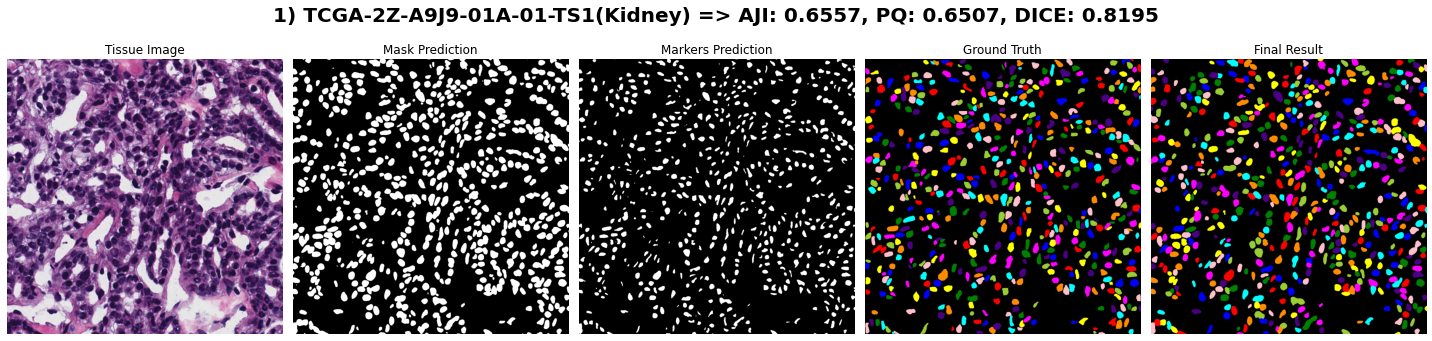

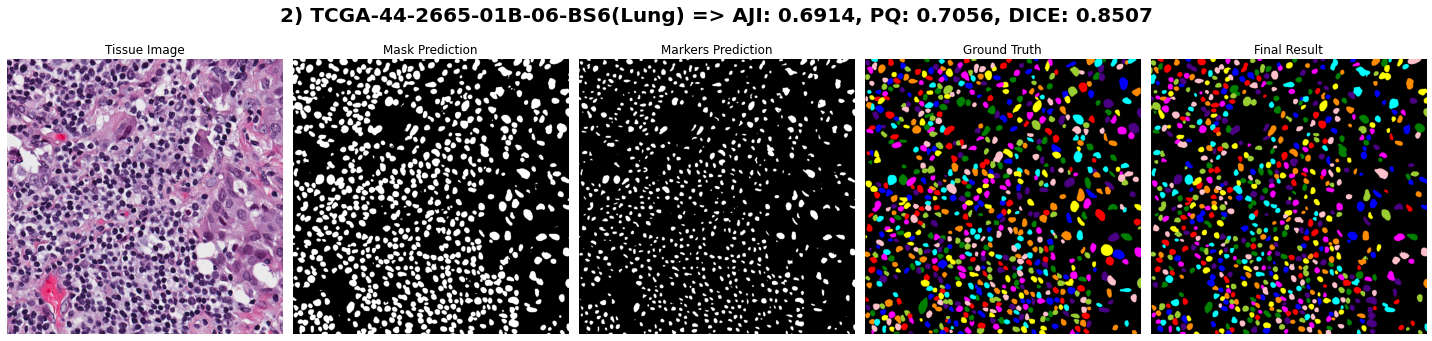

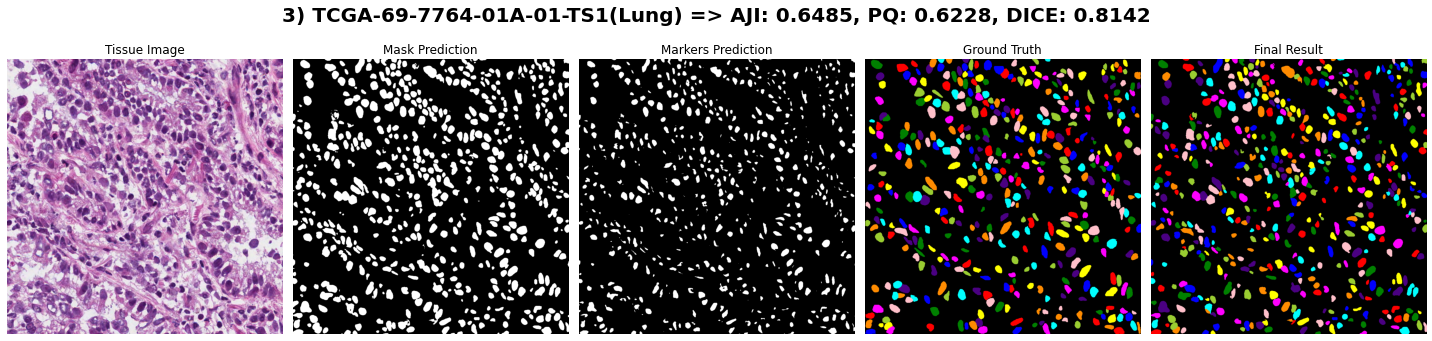

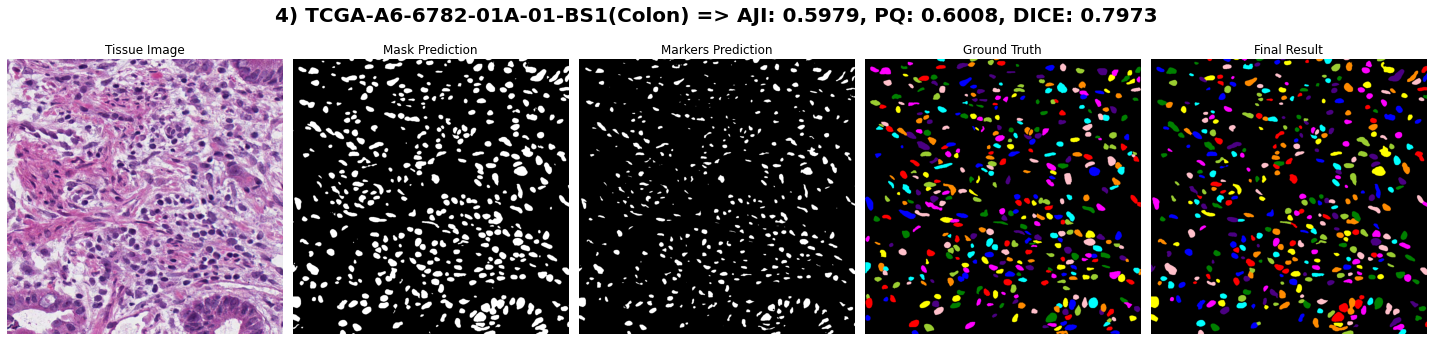

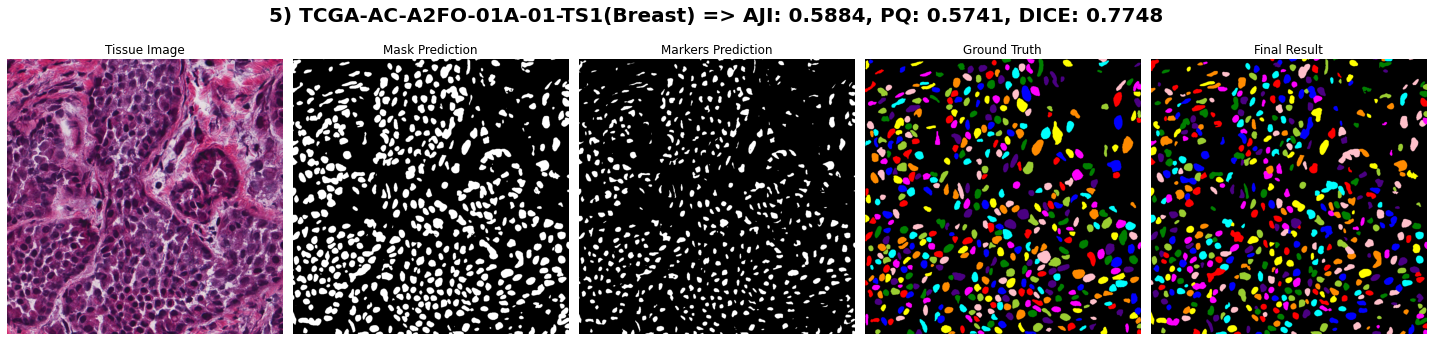

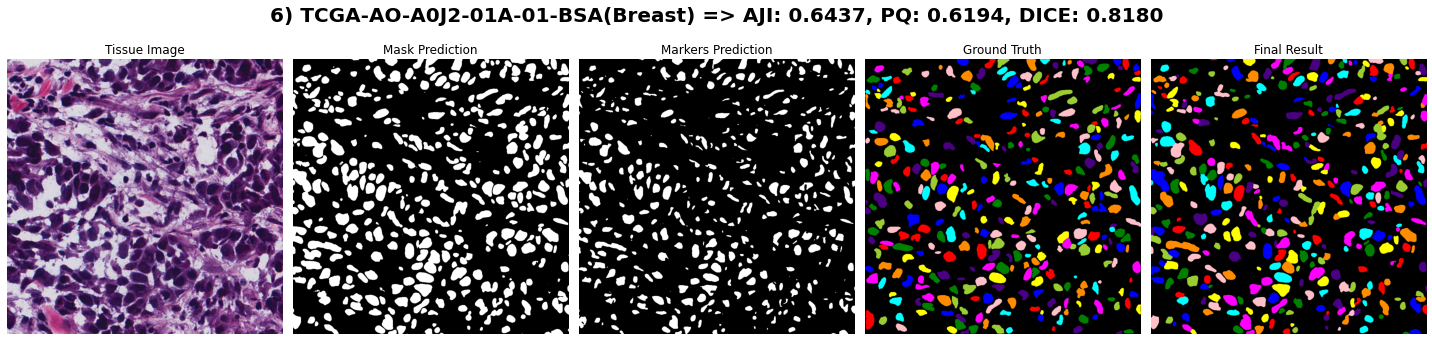

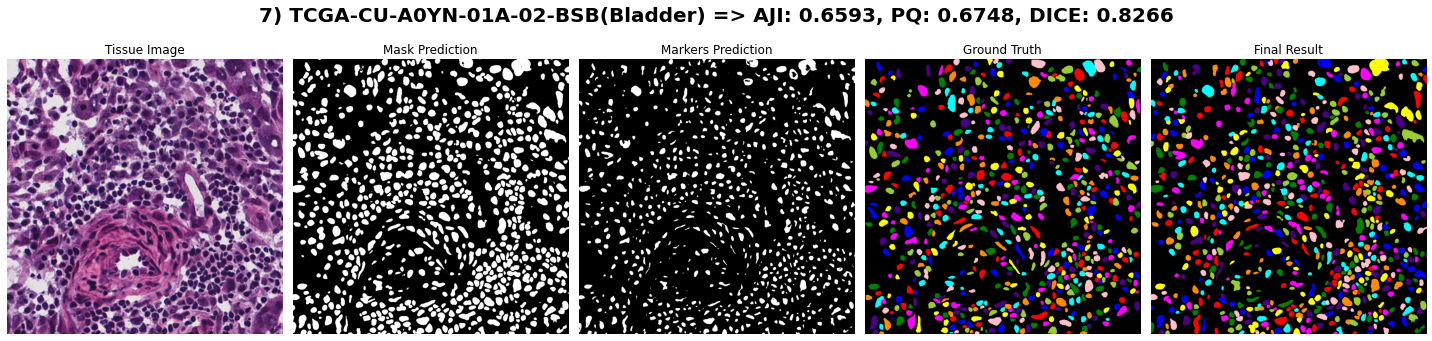

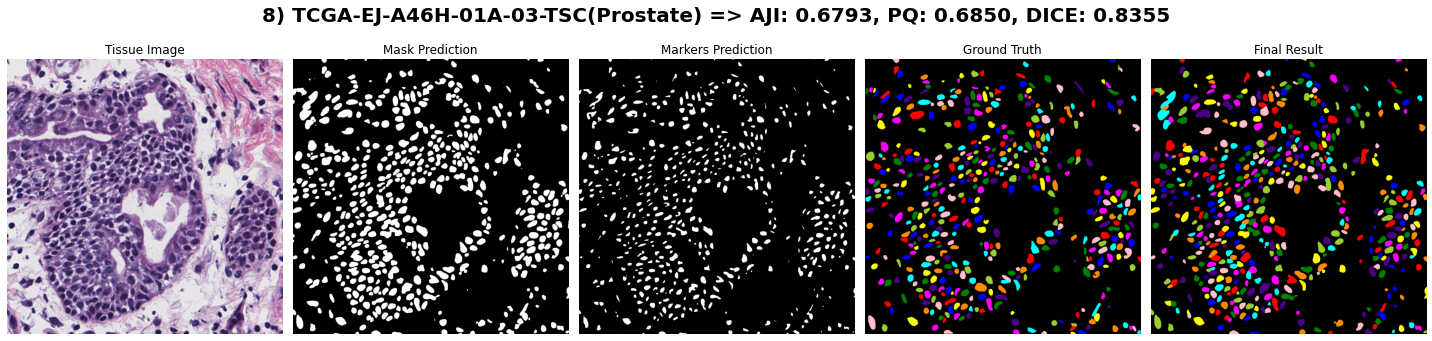

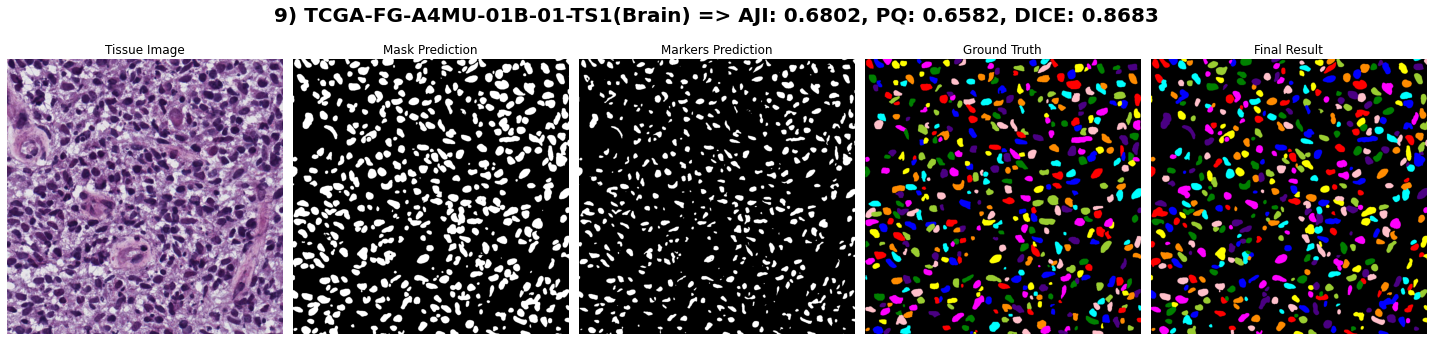

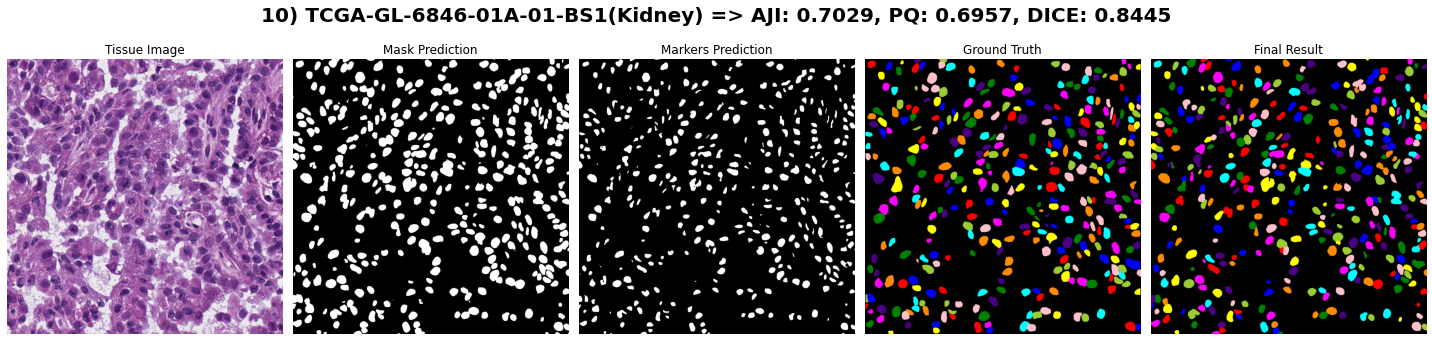

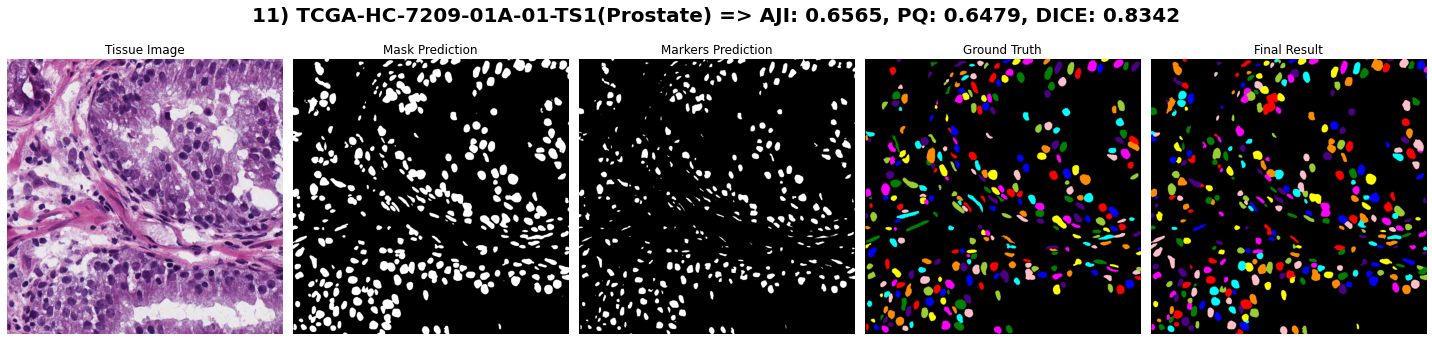

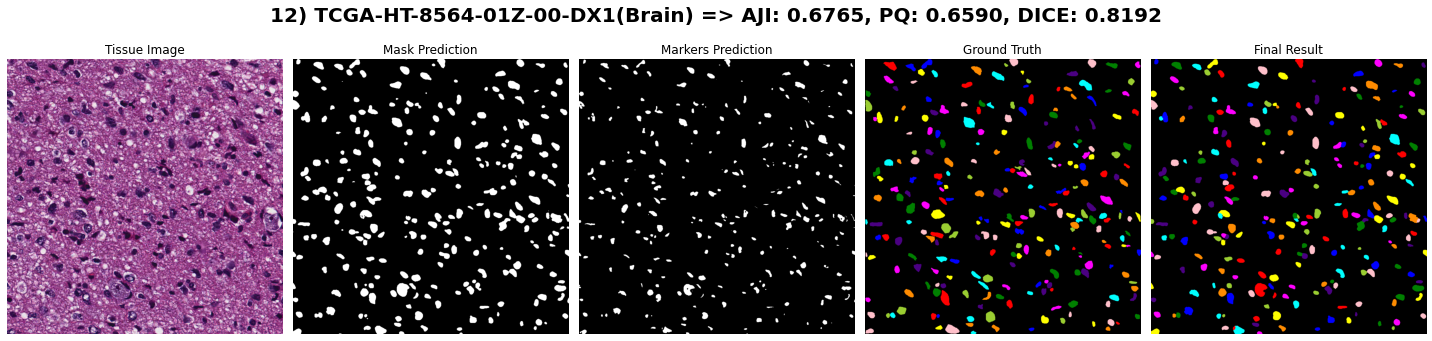

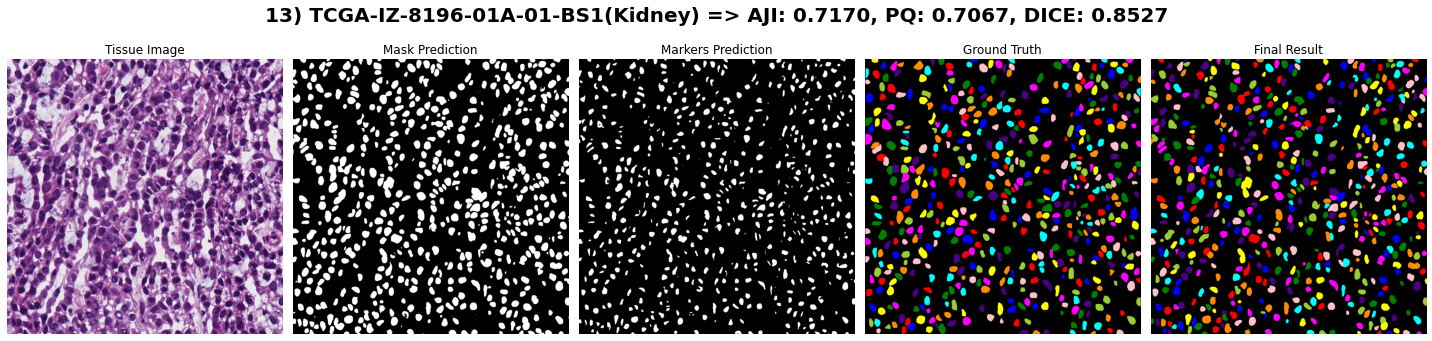

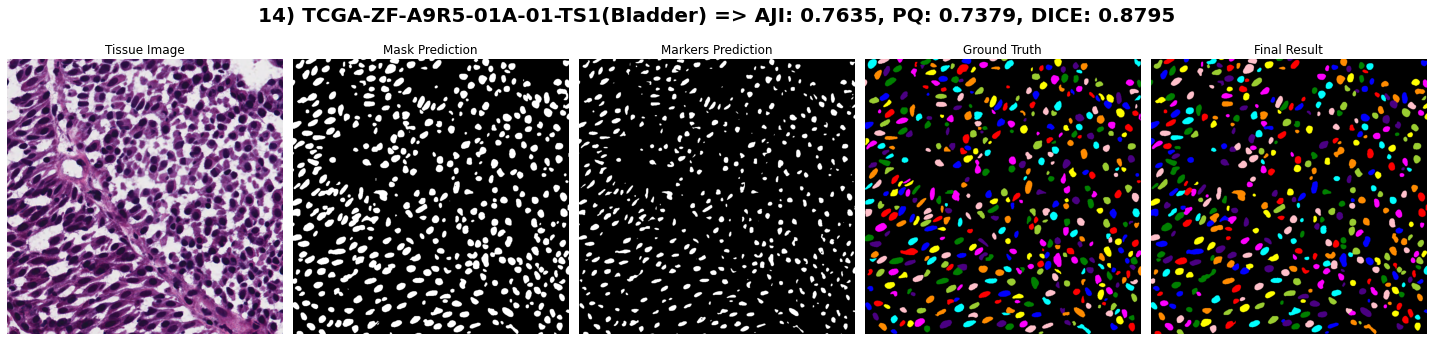

In [29]:
### for all the test images

BINARY_SCORE = []
MULTICLASS_SCORE = []
FINAL_SCORE = []

pre_proc_time = 0
pred_time = 0
tta_time = 0
post_proc_time = 0

n = 0

for image_path in sorted(glob.glob(os.path.join(test_img_dir, "*"))):

    n += 1

    """ extracting the name """
    name = os.path.basename(image_path)
    name = name.split(".")[0]

    """ preprocessing """
    start = time.time()
    # 1) stain normalization
    img, normI = macenko_normalize(image_path, ref_img_dir)
    # 2) resize to 1024 * 1024
    resizedI = cv2.resize(normI, (1024, 1024), cv2.INTER_LINEAR)
    # 3) pixel value normalize between [0, 1]
    normalizedI = resizedI.astype("float32") / 255.
    # 4) expand dimension
    normalizedI = np.expand_dims(normalizedI, axis=0)
    end = time.time()
    pre_proc_time += end - start

    """ make prediction """
    # binary_pred, multi_pred = model.predict(normalizedI, verbose=0)
    # make prediction with TTA (Test Time Augmentation)
    start = time.time()
    pred = model.predict(normalizedI, verbose=0)
    end = time.time()
    pred_time += end - start
    binary_pred_org = (pred[0] + pred[1] + pred[2] + pred[3]) / 4
    multi_pred_org = (pred[4] + pred[5] + pred[6] + pred[7]) / 4
    
    pred_lr = model.predict(np.fliplr(normalizedI), verbose=0)
    binary_pred_lr = (pred_lr[0] + pred_lr[1] + pred_lr[2] + pred_lr[3]) / 4
    multi_pred_lr = (pred_lr[4] + pred_lr[5] + pred_lr[6] + pred_lr[7]) / 4
    binary_pred_lr = np.fliplr(binary_pred_lr)
    multi_pred_lr = np.fliplr(multi_pred_lr)

    pred_ud = model.predict(np.flipud(normalizedI), verbose=0)
    binary_pred_ud = (pred_ud[0] + pred_ud[1] + pred_ud[2] + pred_ud[3]) / 4
    multi_pred_ud = (pred_ud[4] + pred_ud[5] + pred_ud[6] + pred_ud[7]) / 4
    binary_pred_ud = np.flipud(binary_pred_ud)
    multi_pred_ud = np.flipud(multi_pred_ud)

    pred_lr_ud = model.predict(np.fliplr(np.flipud(normalizedI)), verbose=0)
    binary_pred_lr_ud = (pred_lr_ud[0] + pred_lr_ud[1] + pred_lr_ud[2] + pred_lr_ud[3]) / 4
    multi_pred_lr_ud = (pred_lr_ud[4] + pred_lr_ud[5] + pred_lr_ud[6] + pred_lr_ud[7]) / 4
    binary_pred_lr_ud = np.fliplr(np.flipud(binary_pred_lr_ud))
    multi_pred_lr_ud = np.fliplr(np.flipud(multi_pred_lr_ud))

    binary_pred = (binary_pred_org + binary_pred_lr + binary_pred_ud + binary_pred_lr_ud) / 4
    multi_pred = (multi_pred_org + multi_pred_lr + multi_pred_ud + multi_pred_lr_ud) / 4
    end = time.time()
    tta_time += end - start

    # resize to 1000 * 1000
    resized_pred_1 = cv2.resize(binary_pred.squeeze(), (1000, 1000))
    resized_pred_2 = cv2.resize(multi_pred.squeeze(), (1000, 1000))

    # threshold
    start = time.time()
    pred = resized_pred_1 >= 0.5
    pred = pred.astype("int32")

    pred_2 = resized_pred_2 >= 0.5
    pred_2 = pred_2.astype("int32")
    onehot_mask = np.argmax(pred_2, axis=-1)

    # post_processing
    marker_pred = (resized_pred_2[:, :, 2] - resized_pred_2[:, :, 1]) >= 0.5
    marker_pred = morphology.binary_erosion(marker_pred)
    marker_pred = marker_pred.astype("int32")

    grad = filters.scharr(pred)
    marker = pred * marker_pred
    marker_label = measurements.label(marker)[0]
    proced_pred = watershed(grad, marker_label, mask=pred)
    proced_pred = morphology.remove_small_objects(proced_pred, 100)
    binary_objects = proced_pred.astype(bool)
    binary_filled = morphology.remove_small_holes(binary_objects, 40)
    proced_pred = watershed(binary_filled, proced_pred, mask=binary_filled)
    end = time.time()
    post_proc_time += end - start

    # read the mask
    binary_mask_path = image_path.replace("original", 
                                          "stain_normalized").replace("tissue_images", 
                                                                      "binary_masks").replace("tif", "png")
    binary_gt = cv2.imread(binary_mask_path, 0)

    multi_mask_path = image_path.replace("original", 
                                          "stain_normalized").replace("tissue_images", 
                                                                      "modified_masks").replace("tif", "png")
    multi_gt = cv2.imread(multi_mask_path, 0)
    multi_gt[multi_gt==255] = 2
    multi_gt[multi_gt==127] = 1

    instance_gt_path = image_path.replace("original", 
                                          "stain_normalized").replace("tissue_images", 
                                                                      "instance_masks").replace("tif", "npy")
    color_pred = label2rgb(proced_pred, bg_label=0)                                                                  
    ins_gt = np.load(instance_gt_path)
    color_gt = label2rgb(ins_gt, bg_label=0)

    # evaluate
    mask = binary_gt.flatten()
    y_pred = pred.flatten()

    f1_value = f1_score(mask/255, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask/255, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask/255, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask/255, y_pred, labels=[0, 1], average="binary", zero_division=0)

    mask_2 = multi_gt.flatten()
    y_pred_2 = onehot_mask.flatten()

    f1_value_2 = f1_score(mask_2, y_pred_2, labels=[0, 1, 2], average=None)
    jac_value_2 = jaccard_score(mask_2, y_pred_2, labels=[0, 1, 2], average=None)
    recall_value_2 = recall_score(mask_2, y_pred_2, labels=[0, 1, 2], average=None, zero_division=0)
    precision_value_2 = precision_score(mask_2, y_pred_2, labels=[0, 1, 2], average=None, zero_division=0)

    proced_pred = remap_label(proced_pred)
    gt_remap = remap_label(ins_gt.astype("int32"))
    fast_aji = get_fast_aji(gt_remap, proced_pred)
    aji = AJI_Metrics()
    reg_aji= aji.add_prediction(proced_pred, ins_gt)
    score = get_fast_pq(gt_remap, proced_pred)
    dice_score = get_dice_1(gt_remap, proced_pred)
    dice2 = get_fast_dice_2(gt_remap, proced_pred)
    
    # append to SCORE
    BINARY_SCORE.append([name, f1_value, jac_value, recall_value, precision_value])
    binary_df = pd.DataFrame(BINARY_SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])

    MULTICLASS_SCORE.append([
                             name, 
                             f1_value_2[0], f1_value_2[1], f1_value_2[2],
                             jac_value_2[0], jac_value_2[1], jac_value_2[2],
                             recall_value_2[0], recall_value_2[1], recall_value_2[2],
                             precision_value_2[0], precision_value_2[1], precision_value_2[2],
                             ])
    multi_class_df = pd.DataFrame(MULTICLASS_SCORE, columns=["Image", 
                                                             "F1_bg", "F1_border", "F1_marker",
                                                             "Jaccard_bg", "Jaccard_border", "Jaccard_marker",
                                                             "Recall_bg", "Recall_border", "Recall_marker",
                                                             "Precision_bg", "Precision_border", "Precision_marker"])
    
    FINAL_SCORE.append([name, fast_aji, reg_aji, score[0][0], score[0][1], score[0][2], dice_score, dice2])
    final_df = pd.DataFrame(FINAL_SCORE, columns=["Image", "fast_AJI", "AJI", "DQ/F1", "SQ", "PQ", "DICE", "DICE2"])

    fig, ax = plt.subplots(1, 5, figsize=(20, 5.5))
    [axi.axis(False) for axi in ax.ravel()]

    ax[0].imshow(img)
    ax[0].set_title("Tissue Image")

    ax[1].imshow(pred, cmap="gray")
    ax[1].set_title("Mask Prediction")

    ax[2].imshow(marker, cmap="gray")
    ax[2].set_title("Markers Prediction")

    ax[3].imshow(color_gt)
    ax[3].set_title("Ground Truth")

    ax[4].imshow(color_pred)
    ax[4].set_title("Final Result")

    plt.tight_layout()
    plt.suptitle(f"{n}) {name}({test_organs[n-1]}) => AJI: {reg_aji:.4f}, PQ: {score[0][2]:.4f}, DICE: {dice_score:.4f}", fontsize=20, fontweight='bold')
    plt.show()

In [30]:
print(f"Prediction time: {pred_time/14:.3f}s, TTA time: {tta_time/14:.3f}s, Post_processing time: {post_proc_time/14:.3f}s")

Prediction time: 1.113s, TTA time: 3.797s, Post_processing time: 0.130s


In [31]:
binary_df.loc['mean'] = binary_df.mean(numeric_only=True)
# binary_df.to_csv("binary_score_FTL.csv")
binary_df

Image        F1   Jaccard    Recall  Precision
0     TCGA-2Z-A9J9-01A-01-TS1  0.817306  0.691054  0.871669   0.769325
1     TCGA-44-2665-01B-06-BS6  0.851120  0.740826  0.799828   0.909441
2     TCGA-69-7764-01A-01-TS1  0.807910  0.677726  0.800914   0.815030
3     TCGA-A6-6782-01A-01-BS1  0.798864  0.665091  0.803631   0.794154
4     TCGA-AC-A2FO-01A-01-TS1  0.774231  0.631629  0.746734   0.803831
5     TCGA-AO-A0J2-01A-01-BSA  0.817230  0.690945  0.859933   0.778567
6     TCGA-CU-A0YN-01A-02-BSB  0.823740  0.700304  0.874017   0.778932
7     TCGA-EJ-A46H-01A-03-TSC  0.832797  0.713497  0.901179   0.774060
8     TCGA-FG-A4MU-01B-01-TS1  0.866431  0.764340  0.893439   0.841009
9     TCGA-GL-6846-01A-01-BS1  0.844399  0.730701  0.841238   0.847584
10    TCGA-HC-7209-01A-01-TS1  0.836777  0.719361  0.873998   0.802597
11    TCGA-HT-8564-01Z-00-DX1  0.821604  0.697222  0.812886   0.830511
12    TCGA-IZ-8196-01A-01-BS1  0.852340  0.742677  0.844564   0.860261
13    TCGA-ZF-A9R5-01A-01-TS1  0.880791  0.786976  0.875718   0.885923
mean                      NaN  0.830396  0.710882  0.842839   0.820802

In [32]:
multi_class_df.loc['mean'] = multi_class_df.mean(numeric_only=True)
# multi_class_df.to_csv("multi_class_FTL.csv")
multi_class_df

Image     F1_bg  F1_border  F1_marker  Jaccard_bg  \
0     TCGA-2Z-A9J9-01A-01-TS1  0.914630   0.748219   0.775058    0.842689   
1     TCGA-44-2665-01B-06-BS6  0.898090   0.786366   0.814812    0.815030   
2     TCGA-69-7764-01A-01-TS1  0.911493   0.713282   0.781978    0.837380   
3     TCGA-A6-6782-01A-01-BS1  0.938763   0.719339   0.754718    0.884594   
4     TCGA-AC-A2FO-01A-01-TS1  0.877969   0.663706   0.732982    0.782482   
5     TCGA-AO-A0J2-01A-01-BSA  0.911094   0.693085   0.789372    0.836706   
6     TCGA-CU-A0YN-01A-02-BSB  0.889532   0.766975   0.788179    0.801042   
7     TCGA-EJ-A46H-01A-03-TSC  0.942583   0.777719   0.799461    0.891401   
8     TCGA-FG-A4MU-01B-01-TS1  0.932829   0.767769   0.834279    0.874114   
9     TCGA-GL-6846-01A-01-BS1  0.938213   0.727348   0.812874    0.883617   
10    TCGA-HC-7209-01A-01-TS1  0.953701   0.749119   0.808102    0.911500   
11    TCGA-HT-8564-01Z-00-DX1  0.971028   0.718219   0.778633    0.943687   
12    TCGA-IZ-8196-01A-01-BS1  0.927094   0.766335   0.823110    0.864096   
13    TCGA-ZF-A9R5-01A-01-TS1  0.946324   0.787317   0.856504    0.898116   
mean                      NaN  0.925239   0.741771   0.796433    0.861890   

      Jaccard_border  Jaccard_marker  Recall_bg  Recall_border  Recall_marker  \
0           0.597723        0.632730   0.883228       0.767691       0.860832   
1           0.647944        0.687495   0.949002       0.748147       0.760862   
2           0.554343        0.642007   0.913786       0.721549       0.759876   
3           0.561693        0.606062   0.944101       0.698149       0.767619   
4           0.496676        0.578510   0.907624       0.643199       0.691613   
5           0.530322        0.652035   0.894565       0.695679       0.837402   
6           0.622028        0.650409   0.856112       0.795127       0.839795   
7           0.636285        0.665919   0.913602       0.824578       0.873556   
8           0.623072        0.715677   0.910231       0.786127       0.883120   
9           0.571522        0.684741   0.942019       0.713025       0.819146   
10          0.598874        0.677996   0.950306       0.739462       0.845608   
11          0.560329        0.637510   0.979163       0.678538       0.775112   
12          0.621185        0.699395   0.926008       0.760371       0.838103   
13          0.649235        0.749022   0.960197       0.760108       0.849162   
mean        0.590802        0.662822   0.923567       0.737982       0.814415   

      Precision_bg  Precision_border  Precision_marker  
0         0.948347          0.729710          0.704828  
1         0.852362          0.828700          0.876996  
2         0.909213          0.705203          0.805405  
3         0.933486          0.741856          0.742243  
4         0.850191          0.685564          0.779616  
5         0.928246          0.690510          0.746552  
6         0.925666          0.740749          0.742540  
7         0.973463          0.735900          0.736953  
8         0.956578          0.750248          0.790557  
9         0.934438          0.742259          0.806697  
10        0.957120          0.759033          0.773781  
11        0.963027          0.762829          0.782187  
12        0.928183          0.772392          0.808645  
13        0.932846          0.816545          0.863975  
mean      0.928083          0.747250          0.782927

In [33]:
final_df.loc['mean'] = final_df.mean(numeric_only=True)
# final_df.to_csv("results/Unet++/FINAL_SCORE.csv")
final_df

Image  fast_AJI       AJI     DQ/F1        SQ  \
0     TCGA-2Z-A9J9-01A-01-TS1  0.649764  0.655684  0.853265  0.762583   
1     TCGA-44-2665-01B-06-BS6  0.689568  0.691417  0.896985  0.786639   
2     TCGA-69-7764-01A-01-TS1  0.653207  0.648523  0.807377  0.771355   
3     TCGA-A6-6782-01A-01-BS1  0.593198  0.597859  0.806039  0.745428   
4     TCGA-AC-A2FO-01A-01-TS1  0.587357  0.588378  0.788444  0.728109   
5     TCGA-AO-A0J2-01A-01-BSA  0.632327  0.643717  0.814913  0.760114   
6     TCGA-CU-A0YN-01A-02-BSB  0.657461  0.659269  0.864635  0.780457   
7     TCGA-EJ-A46H-01A-03-TSC  0.674056  0.679267  0.865031  0.791843   
8     TCGA-FG-A4MU-01B-01-TS1  0.675759  0.680231  0.830671  0.792385   
9     TCGA-GL-6846-01A-01-BS1  0.702271  0.702934  0.882192  0.788581   
10    TCGA-HC-7209-01A-01-TS1  0.666260  0.656533  0.831361  0.779300   
11    TCGA-HT-8564-01Z-00-DX1  0.670895  0.676506  0.892495  0.738402   
12    TCGA-IZ-8196-01A-01-BS1  0.716238  0.716974  0.900722  0.784643   
13    TCGA-ZF-A9R5-01A-01-TS1  0.758030  0.763520  0.923409  0.799061   
mean                      NaN  0.666171  0.668629  0.854110  0.772064   

            PQ      DICE     DICE2  
0     0.650686  0.819533  0.747569  
1     0.705603  0.850735  0.711922  
2     0.622775  0.814192  0.743433  
3     0.600845  0.797265  0.740179  
4     0.574073  0.774800  0.705443  
5     0.619427  0.818000  0.757271  
6     0.674810  0.826562  0.791891  
7     0.684969  0.835484  0.802502  
8     0.658211  0.868345  0.755044  
9     0.695680  0.844479  0.753109  
10    0.647879  0.834196  0.740043  
11    0.659020  0.819159  0.784503  
12    0.706745  0.852739  0.817279  
13    0.737860  0.879512  0.848070  
mean  0.659899  0.831071  0.764161